### plot schedule for job allocation problems considering sequence-dependent set-up times

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib.font_manager import FontProperties

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 14})

def schedulePlot(schedule, car, businessMode=False):
    # variables
    tMax = 17280
    periodLength = 12
    start_dt = datetime.strptime('2022/01/27 00:00:00', '%Y/%m/%d %H:%M:%S')
    period_dt = [start_dt + timedelta(hours=x*12) for x in range(periodLength*2 + 1)] 
    period = [t.strftime('%Y/%m/%d %H:%M') for t in period_dt]
    # about figures
    figSize = 10         
    labelMargin = 60
    # color palette
    color = sns.color_palette("pastel")

    # plot
    fig, ax = plt.subplots(figsize=(figSize * 2, car.shape[0] * 1.5))
    #colorAdded = [False, False, False, False, False, False]
    for i in range(schedule.shape[0]):
        # 分類: 調度與否 & 換車 or 升等
        color_mode = ['升等且車會被調度', '升等且車不會被調度', '正常且車會被調度', '正常且車不會被調度', '換車且車會被調度', '換車且車不會被調度']
        colorIndex = 0
        if schedule['readyToMoveTime'][i] < 0:   # 不調度
            target_car = car[car['car_id'] == schedule['car_id'][i]]
            if target_car['carLevel'].squeeze() > schedule['carLevel'][i]:   # 升等
                colorIndex = 2
            elif schedule['carModelCode'][i] != "N" and target_car['carModelCode'].squeeze() != schedule['carModelCode'][i]:   # 換車
                colorIndex = 6
            else:   # 正常
                colorIndex = 4
        else:   # 調度
            target_car = car[car['car_id'] == schedule['car_id'][i]]
            if target_car['carLevel'].squeeze() > schedule['carLevel'][i]:   # 升等
                colorIndex = 1
            elif schedule['carModelCode'][i] != "N" and target_car['carModelCode'].squeeze() != schedule['carModelCode'][i]:   # 換車
                colorIndex = 5
            else:   # 正常
                colorIndex = 3
        #print(colorIndex)
        
        car_r = car.reset_index()
        car_i = car_r[car_r['car_id'] == schedule['car_id'][i]]
        carIndex = int(car_i.iloc[0]['index'] + 1)
        # 開始時間 - 還車時間
        orderRec = [(schedule['departTime'][i], schedule['returnTime'][i] - schedule['departTime'][i])]   # rectangle size
        if businessMode == False:
            s = "%s"%schedule['order_id'][i] + ", carLevel = " + "%s"%schedule['carLevel'][i] + ", carMCode = " + "%s"%schedule['carModelCode'][i] + ", " + "%s"%color_mode[colorIndex - 1]
        else:
            s = "%s"%schedule['order_id'][i] + ", " + "%s"%color_mode[colorIndex - 1]
        ax.broken_barh(orderRec, ((carIndex - 0.25), 0.5), facecolors = color[colorIndex], label=s, edgecolor="black", zorder=2)
        ax.text(x=(schedule['departTime'][i] + schedule['returnTime'][i])/2, 
                y=carIndex, 
                s="%s"%schedule['order_id'][i], 
                ha='center', 
                va='center',
                color='black'
        )
        ax.text(x=schedule['departTime'][i] + labelMargin, 
                y=carIndex, 
                s="%s"%schedule['departStation'][i], 
                ha='left', 
                va='center',
                color='black'
        )
        ax.text(x=schedule['returnTime'][i] - labelMargin, 
                y=carIndex, 
                s="%s"%schedule['returnStation'][i], 
                ha='right', 
                va='center',
                color='black'
        )
        # 還車時間 - 整備時間
        orderRec = [(schedule['returnTime'][i], schedule['finishCleaningTime'][i] - schedule['returnTime'][i])]   # rectangle size
        ax.broken_barh(orderRec, ((carIndex - 0.25), 0.5), facecolors = color[colorIndex], edgecolor="black", zorder=2)
        ax.text(x=(schedule['returnTime'][i] + schedule['finishCleaningTime'][i])/2, 
                y=carIndex, 
                s="整備", 
                ha='center', 
                va='center',
                color='black'
        )
        # optional: 整備時間 - 預留時間
        if schedule['readyToMoveTime'][i] > 0:
            orderRec = [(schedule['finishCleaningTime'][i], schedule['readyToMoveTime'][i] - schedule['finishCleaningTime'][i])]   # rectangle size
            ax.broken_barh(orderRec, ((carIndex - 0.25), 0.5), facecolors = color[colorIndex], edgecolor="black", zorder=2)
            ax.text(x=(schedule['finishCleaningTime'][i] + schedule['readyToMoveTime'][i])/2, 
                    y=carIndex, 
                    s="預留", 
                    ha='center', 
                    va='center',
                    color='black'
            )
            if schedule['nextOrderDepartTime'][i] > 0:
                orderRec = [(schedule['readyToMoveTime'][i], schedule['nextOrderDepartTime'][i] - schedule['readyToMoveTime'][i])]   # rectangle size
                ax.broken_barh(orderRec, ((carIndex - 0.25), 0.5), facecolors = color[colorIndex], edgecolor="black", zorder=2)
                ax.text(x=(schedule['readyToMoveTime'][i] + schedule['nextOrderDepartTime'][i])/2, 
                        y=carIndex, 
                        s="移車", 
                        ha='center', 
                        va='center',
                        color='black'
                )
            

    ax.set_xlim([0, tMax])
    ax.set_xticks(np.arange(0, tMax + 1, 720))
    ax.set_xticklabels(period, rotation=45, ha="right")
    ax.set_xlabel('Time')
    ax.set_ylim([0.5, car.shape[0] + 0.5])
    ax.set_yticks(np.arange(1, car.shape[0] + 1, 1))
    ax.set_yticklabels(list(car['car_id']))
    ax.set_ylabel('Car')

    ax.set_title('Schedule Plot')
    ax.legend(loc = "upper left",bbox_to_anchor=(1, 1))
    if businessMode == True:
        ax.get_legend().set_title("order_id")
    else:
        ax.get_legend().set_title("")
    plt.grid()
    plt.show()

### Example

#### step 1 : declare input variable

In [5]:
# color palette
color = sns.color_palette("pastel")

# variables
# order
order_id = ['1', '2', '3', '4', '5', '6', '7']
order_carId = ['01', '02', '03', '01', '02', '03', '01'] 
order_carLevel = [1, 1, 1, 1, 2, 3, 1]
order_carModelCode = ['N', 'N', '33', '11', '44', '44', 'N']   # 不指定車型，carModelCode = 'N'
order_departStation = ['A', 'C', 'A', 'C', 'A', 'C', 'A']
order_returnStation = ['B', 'A', 'B', 'A', 'B', 'A', 'C']
order_departTime = [1000, 8000, 1000, 7000, 1000, 8000, 12000]
order_returnTime = [4000, 9000, 4000, 8000, 3000, 9000, 13000]   # 還車時間
order_finishCleaningTime = [5000, 10000, 5000, 9000, 4000, 10000, 14000]   # 整備時間
order_readyToMoveTime = [6000, -1, 6000, -1, 6000, -1, -1]   # 預留開始時間: 如果沒有調度，readyToMoveTime 就和整備時間相同
order_nextOrderDepartTime = [7000, -1, 8000, 12000, 8000, -1, -1]
# car
car_id = ['01', '02', '03']
car_carLevel = [1, 2, 3]
car_carModelCode = ['11', '22', '33']
# time
tMax = 17280
periodLength = 12
start_dt = datetime.strptime('2022/01/27 00:00:00', '%Y/%m/%d %H:%M:%S')
period_dt = [start_dt + timedelta(hours=x*12) for x in range(periodLength*2 + 1)] 
period = [t.strftime('%Y/%m/%d %H:%M') for t in period_dt]
# about figures
figSize = 10         
labelMargin = 60

# build dataframes
schedule = pd.DataFrame({
    'order_id': order_id, 
    'car_id': order_carId,
    'carLevel': order_carLevel,   # 原本想要的車型方案
    'carModelCode': order_carModelCode,   # 原本想要的車型代碼
    'departStation': order_departStation,
    'returnStation': order_returnStation,
    'departTime': order_departTime,
    'returnTime': order_returnTime,
    'finishCleaningTime': order_finishCleaningTime,
    'readyToMoveTime': order_readyToMoveTime,
    'nextOrderDepartTime': order_nextOrderDepartTime,
})
print("schedule: ")
display(schedule)

car = pd.DataFrame({
    'car_id': car_id,
    'carLevel': car_carLevel,
    'carModelCode': car_carModelCode,
})
print("car: ")
display(car)

schedule: 


,order_id,car_id,carLevel,carModelCode,departStation,returnStation,departTime,returnTime,finishCleaningTime,readyToMoveTime,nextOrderDepartTime
0,1,01,1,N,A,B,1000,4000,5000,6000,7000
1,2,02,1,N,C,A,8000,9000,10000,-1,-1
2,3,03,1,33,A,B,1000,4000,5000,6000,8000
3,4,01,1,11,C,A,7000,8000,9000,-1,12000
4,5,02,2,44,A,B,1000,3000,4000,6000,8000
5,6,03,3,44,C,A,8000,9000,10000,-1,-1
6,7,01,1,N,A,C,12000,13000,14000,-1,-1


car: 


,car_id,carLevel,carModelCode
0,01,1,11
1,02,2,22
2,03,3,33


#### step 2 : call function

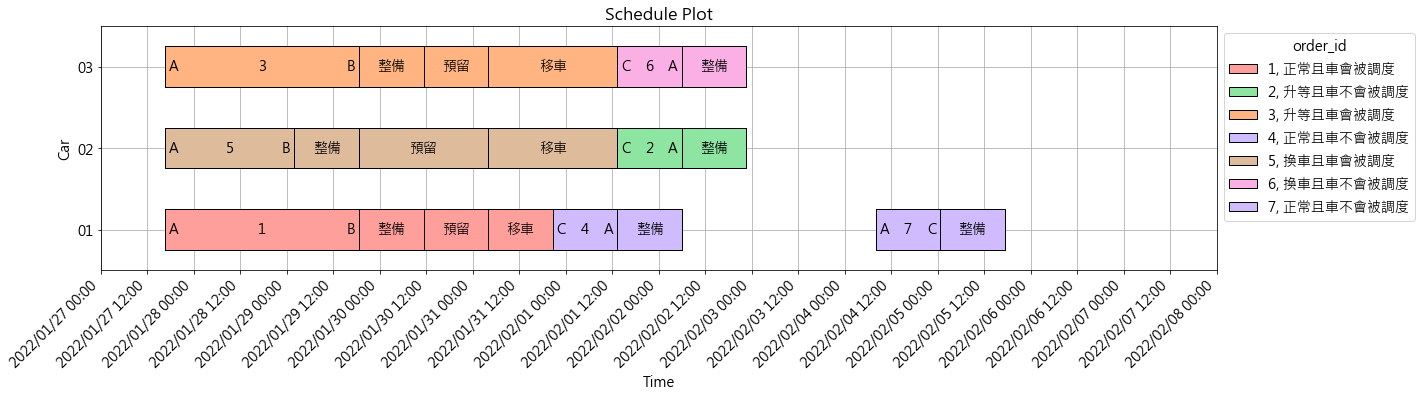

In [6]:
schedulePlot(schedule, car, True)